# Setup

In [1]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import keras
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

# Data preprocessed

In [8]:
df = pd.read_csv('../dataset/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

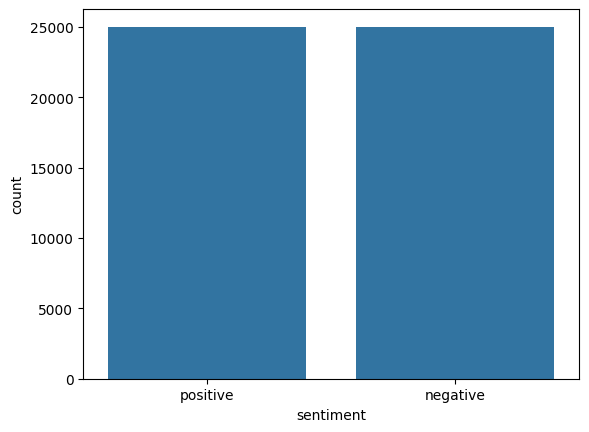

In [9]:
# Plot positif dan negatif
sns.countplot(x='sentiment', data=df)

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

In [11]:
def preprocess(text):
    # preprocess html tag
    text = re.sub(r'<.*?>', '', text)
    # preprocess non-alphabet
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # lowercase
    text = text.lower()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # stemmer
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # remove extra space
    text = re.sub(r'\s+', ' ', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

df['review'] = df['review'].apply(preprocess)

In [3]:
# preprocess sentiment
def sentiment(sentiment):
    if sentiment == 'positive':
        return 1
    else:
        return 0
    
df['sentiment'] = df['sentiment'].apply(sentiment)

# Word cloud

In [2]:
df = pd.read_csv('../dataset/IMDB Dataset Preprocessed.csv')
df.head()

,review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


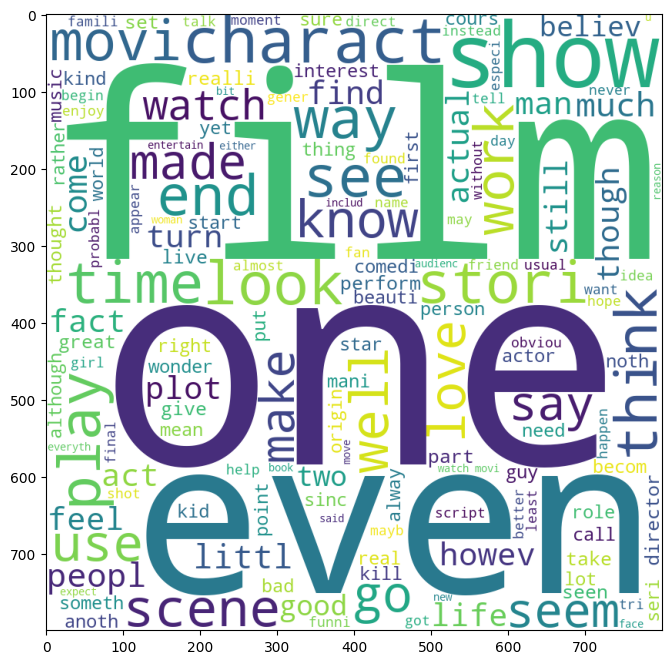

In [3]:
# Wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(' '.join(df['review']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

# Modelling

In [9]:
X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

tokenizer_json = tokenizer.to_json()
with open('../model/tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_json)
    
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

In [11]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [12]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=1)
csv_logger = keras.callbacks.CSVLogger('../dataset/training.csv')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=4,
    callbacks=[early_stop, csv_logger]
)

Epoch 1/4
1250/1250 [==============================] - 505s 393ms/step - loss: 0.3521 - binary_accuracy: 0.8486 - val_loss: 0.2892 - val_binary_accuracy: 0.8829
Epoch 2/4
1250/1250 [==============================] - 398s 319ms/step - loss: 0.2029 - binary_accuracy: 0.9254 - val_loss: 0.3249 - val_binary_accuracy: 0.8790


In [14]:
evaluation = model.evaluate(X_test, y_test)
print(f'Loss: {evaluation[0]}')
print(f'Accuracy: {evaluation[1]}')

313/313 [==============================] - 25s 81ms/step - loss: 0.3249 - binary_accuracy: 0.8790
Loss: 0.3248741030693054
Accuracy: 0.8790000081062317


In [15]:
# saved best model
model.save('../model/sentiment_analysis.h5')

# Testing

In [16]:
import nltk
import keras
import re
import tensorflow as tf

from keras_preprocessing.text import tokenizer_from_json
from keras_preprocessing.sequence import pad_sequences

In [17]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

In [18]:
def preprocess(text):
    # preprocess html tag
    text = re.sub(r'<.*?>', '', text)
    # preprocess non-alphabet
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # lowercase
    text = text.lower()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # stemmer
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # remove extra space
    text = re.sub(r'\s+', ' ', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [19]:
# load tokenizer
with open('../model/tokenizer.json') as json_file:
    tokenizer_json = json_file.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

In [22]:
def testing(text):
    model = keras.models.load_model('../model/sentiment_analysis.h5')
   
    text = preprocess(text)
    text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=200)
    text = tf.convert_to_tensor(text)
    score = model.predict(text)[0]
    print(f'Sentiment: {round(score[0] * 100, 2)}%')

In [23]:
testing("I just saw an advance screening of Get Smart and it was great! It was simply the best adaptation of a classic TV series for the big screen. I don't know how to explain it but it successfully carried the tone that the original series had. It was silly but not too silly and, at the same time, a little serious but not too serious. Familiar characters, props, music, jokes and lines all brought back fond memories of a delightful TV series. And there were plenty of new elements in this film that made it interesting and entertaining to watch. Steve Carrell was terrific as Agent 86 and seemed to capture the essence of Maxwell Smart. Not only did his portrayal of him resembled that of Don Adams' from the sound of Smart's voice to the delivery of Smart's lines, Carrell managed to inject a bit of his own personality to create a new Smart that didn't stray too far away from the old. Anne Hathaway was perfect as Agent 99. She did bear some resemblance to Barbara Feldon and actually delivered her lines in a similar manner as her at times. But more importantly, she had great chemistry with Carrell. A key ingredient to Get Smart's success was Maxwell Smart and Agent 99's chemistry and I'm glad the writers of this film didn't forget that. Feldon and Adams had terrific chemistry and so too did Hathaway and Carrell. Unlike previous film adaptations of old television series that only superficially resembled their TV series counterpart, this film can truly be considered a big screen version of the Get Smart TV series. Where Lost In Space, Mission Impossible, Charlie's Angels, Starsky and Hutch and (have I missed anything?) have failed, this film succeeded in maintaining the tone and style of the original series upon which it's based. Moreover, the filmmakers managed to bring Get Smart up to date without forgetting its roots. New ideas created for this film seemed to be natural extensions of those used for the original series. Jokes, props, music, characters and plot, old and new, all seemed to be born from the Get Smart world. I wish I could get into more details but I don't want to give anything away. I thoroughly enjoyed this film and highly recommend this to anyone, especially fans of the original TV series.")
testing("This might be controversial to say but this is my personal favorite MCU movie. Up until this point, nothing had been done like this in film and it was executed magnificently. Going into this movie in 2012 (having only seen Iron Man beforehand) I was skeptical and not interested. Then my brother took us to the theater to see it and it was one hell of a blast. I was blown away and wanted to watch all of the other Phase 1 movies and learn more about these other heroes. The casting and chemistry between them is on point, the villain is compelling and gets under your skin in the best way, and Robert Downey Jr.'s humor all around is unforgettable, and how can I not mention that glorifying theme song?? Not to mention Stan Lee's perfect cameo!")

1/1 [==============================] - 2s 2s/step
Sentiment: 97.93%
1/1 [==============================] - 2s 2s/step
Sentiment: 85.89%
